In [10]:
import pandas as pd

from dpks.quant_matrix import QuantMatrix
from dpks.differential_testing import DifferentialTest

quant_matrix = QuantMatrix(
    quantification_file="../tests/input_files/de_matrix.tsv",
    design_matrix_file="../tests/input_files/de_design_matrix.tsv",
)

In [11]:
quantified_data = (
    quant_matrix.filter().normalize(
        method="mean",
        log_transform=True,
        use_rt_sliding_window_filter=True,
        minimum_data_points=100,
        stride=5,
        use_overlapping_windows=True,
        rt_unit="minutes",
    ).scale("minmax")
    # .quantify(method="top_n", top_n=1)
)
quantified_data.to_df()

All-NaN slice encountered
All-NaN slice encountered
invalid value encountered in true_divide


,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,AAS_P2009_167,AAS_P2009_169,AAS_P2009_176,...,AAS_P2009_205,AAS_P2009_212,AAS_P2009_214,AAS_P2009_221,AAS_P2009_230,AAS_P2009_232,AAS_P2009_239,AAS_P2009_241,AAS_P2009_248,AAS_P2009_250
0,YVASYLLAALGGNSSPSAK,2,0,sp|P99027|RLA2_MOUSE,1075.710,0.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TGTLTTSETAHNM(UniMod:35)K,3,0,sp|P32324|EF2_YEAST,1648.580,0.000000,0.0,NaN,0.333194,NaN,...,0.087201,NaN,0.129755,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2,THNDIIHNENM(UniMod:35)R,3,0,sp|P26040|EZRI_MOUSE,1779.425,0.008803,0.0,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DSVTYTEHAK,2,0,sp|P02309|H4_YEAST,1830.600,0.000261,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,IHMGNC(UniMod:4)AENTAK,3,0,sp|Q8QZT1|THIL_MOUSE,1842.815,0.003430,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16674,NAADM(UniMod:35)VLLDDNFASIVTGVEEGR,3,0,sp|Q9Z1W8|AT12A_MOUSE,7308.245,0.000000,0.0,0.000000,0.901836,NaN,...,0.718511,0.300134,0.750531,0.253176,0.726222,0.293171,0.635990,0.824804,0.181598,0.365843
16675,SNLVGMGVIPLEYLPGETADSLGLTGR,3,0,sp|P28271|ACOHC_MOUSE,7311.770,0.003138,0.0,NaN,NaN,NaN,...,NaN,0.205357,0.504769,0.000000,0.672077,0.068701,NaN,0.618545,0.099477,0.202479
16676,LFSGEDVLYEGDSIVYPVFINEAAYYEK,3,0,sp|Q91XE4|ACY3_MOUSE,7315.150,0.009142,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16677,LLPWFDGMLEADEAYFK,2,0,sp|P14540|ALF_YEAST,7331.240,0.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
compared_data = quantified_data.compare(
    method="anova",
    comparisons=(4, 6),
    min_samples_per_group=2,
    level="precursor",
    multiple_testing_correction_method="fdr_tsbh",
)

compared_data.to_df()

,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,PrecursorId,DEScore4-6,Group4Mean,...,AAS_P2009_205,AAS_P2009_212,AAS_P2009_214,AAS_P2009_221,AAS_P2009_230,AAS_P2009_232,AAS_P2009_239,AAS_P2009_241,AAS_P2009_248,AAS_P2009_250
0,YVASYLLAALGGNSSPSAK,2,0,sp|P99027|RLA2_MOUSE,1075.710,0.000000,0.0,YVASYLLAALGGNSSPSAK_2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TGTLTTSETAHNM(UniMod:35)K,3,0,sp|P32324|EF2_YEAST,1648.580,0.000000,0.0,TGTLTTSETAHNM(UniMod:35)K_3,NaN,NaN,...,0.087201,NaN,0.129755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,THNDIIHNENM(UniMod:35)R,3,0,sp|P26040|EZRI_MOUSE,1779.425,0.008803,0.0,THNDIIHNENM(UniMod:35)R_3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DSVTYTEHAK,2,0,sp|P02309|H4_YEAST,1830.600,0.000261,0.0,DSVTYTEHAK_2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IHMGNC(UniMod:4)AENTAK,3,0,sp|Q8QZT1|THIL_MOUSE,1842.815,0.003430,0.0,IHMGNC(UniMod:4)AENTAK_3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16674,NAADM(UniMod:35)VLLDDNFASIVTGVEEGR,3,0,sp|Q9Z1W8|AT12A_MOUSE,7308.245,0.000000,0.0,NAADM(UniMod:35)VLLDDNFASIVTGVEEGR_3,0.080841,0.577418,...,0.718511,0.300134,0.750531,0.253176,0.726222,0.293171,0.635990,0.824804,0.181598,0.365843
16675,SNLVGMGVIPLEYLPGETADSLGLTGR,3,0,sp|P28271|ACOHC_MOUSE,7311.770,0.003138,0.0,SNLVGMGVIPLEYLPGETADSLGLTGR_3,0.118192,0.348623,...,NaN,0.205357,0.504769,NaN,0.672077,0.068701,NaN,0.618545,0.099477,0.202479
16676,LFSGEDVLYEGDSIVYPVFINEAAYYEK,3,0,sp|Q91XE4|ACY3_MOUSE,7315.150,0.009142,0.0,LFSGEDVLYEGDSIVYPVFINEAAYYEK_3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16677,LLPWFDGMLEADEAYFK,2,0,sp|P14540|ALF_YEAST,7331.240,0.000000,0.0,LLPWFDGMLEADEAYFK_2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Log2FoldChange4-6', ylabel='LogPValue4-6'>

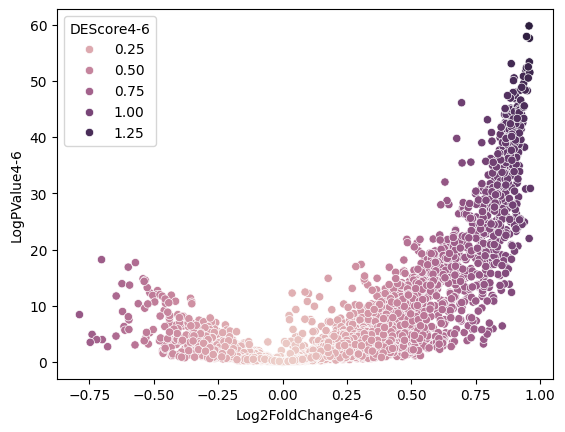

In [13]:
import seaborn as sns
import numpy as np

compared_data.row_annotations["LogPValue4-6"] = compared_data.row_annotations[
    "PValue4-6"
].apply(lambda x: -np.log(x))

sns.scatterplot(
    data=compared_data.row_annotations,
    x="Log2FoldChange4-6",
    y="LogPValue4-6",
    hue="DEScore4-6",
)

In [14]:
compared_data.row_annotations["Species"] = np.where(
    compared_data.row_annotations["Protein"].str.contains("MOUSE"),
    "MOUSE",
    np.where(
        compared_data.row_annotations["Protein"].str.contains("YEAST"),
        "YEAST",
        np.where(
            compared_data.row_annotations["Protein"].str.contains("RT"), "RT", "NONE"
        ),
    ),
)

<Axes: xlabel='Group6Mean', ylabel='Log2FoldChange4-6'>

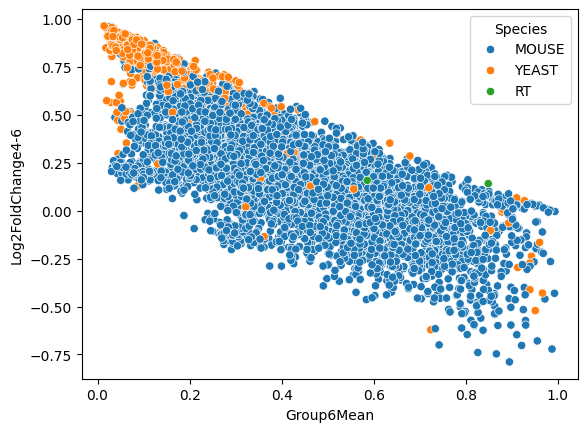

In [15]:
sns.scatterplot(
    data=compared_data.row_annotations,
    x="Group6Mean",
    y="Log2FoldChange4-6",
    hue="Species",
)

In [16]:
cutoffs = np.linspace(0.0, 1.0, num=10000)

In [18]:
precision_roc_data = []

for cutoff in cutoffs[1:]:
    yeast_ids = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue4-6"] <= cutoff)
        & (compared_data.row_annotations["Species"] == "YEAST")
    ].shape[0]

    yeast_fn = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue4-6"] > cutoff)
        & (compared_data.row_annotations["Species"] == "YEAST")
    ].shape[0]

    mouse_ids = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue4-6"] <= cutoff)
        & (compared_data.row_annotations["Species"] == "MOUSE")
    ].shape[0]

    mouse_tn = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue4-6"] > cutoff)
        & (compared_data.row_annotations["Species"] == "MOUSE")
    ].shape[0]

    recall = yeast_ids / (yeast_ids + yeast_fn)

    precision = yeast_ids / (yeast_ids + mouse_ids)
    fpr = mouse_ids / (mouse_ids + mouse_tn)

    precision_roc_data.append({"recall": recall, "precision": precision, "fpr": fpr})

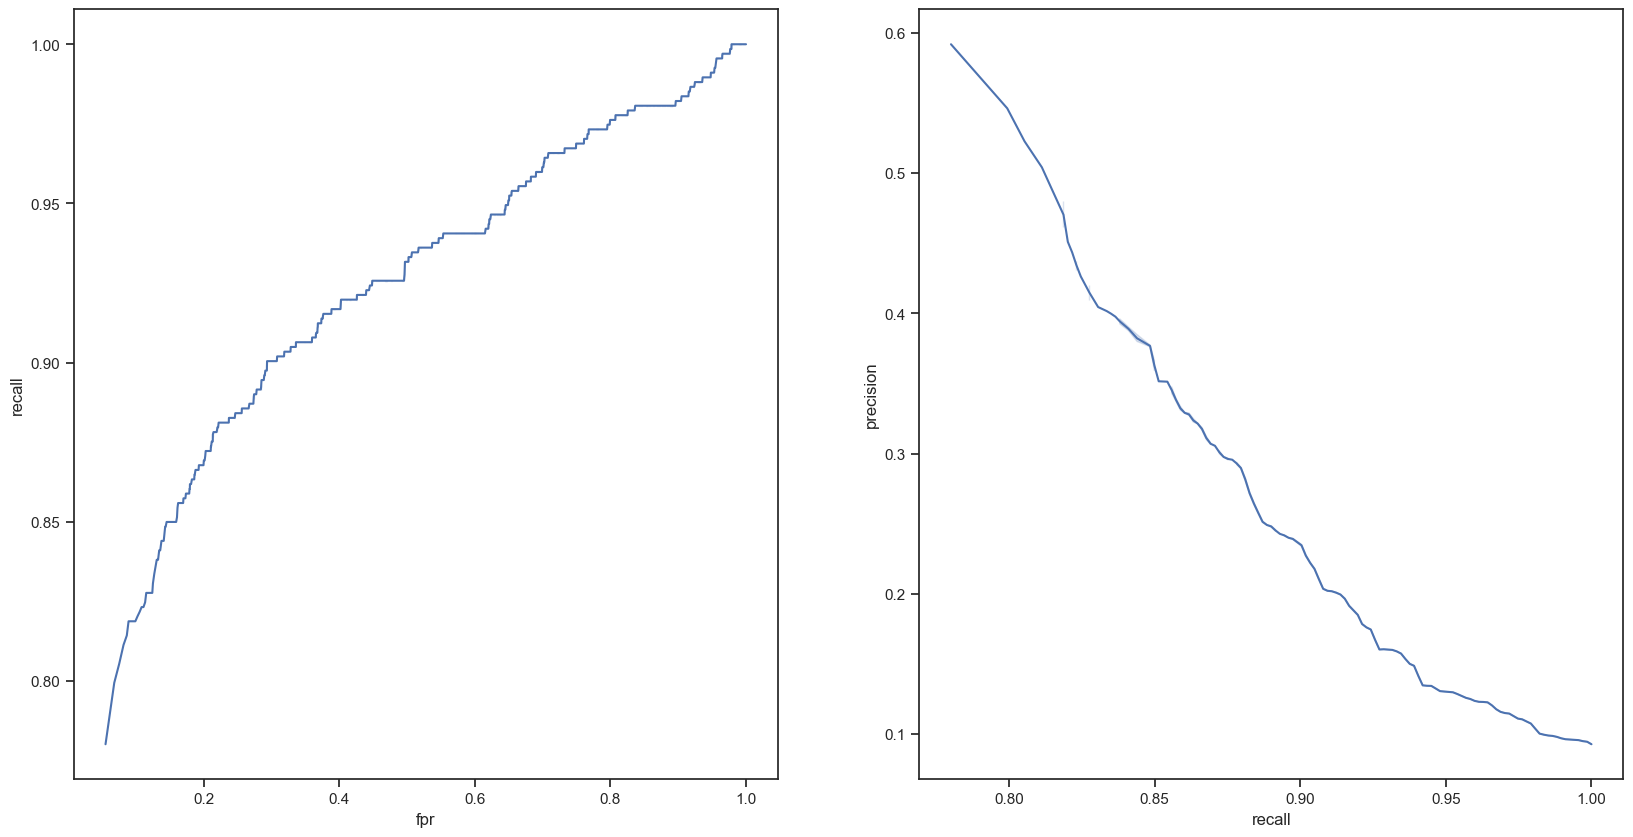

In [19]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

sns.set(font_scale=1, style="ticks")

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

sns.lineplot(
    data=pd.DataFrame(precision_roc_data),
    x="fpr",
    y="recall",
    ax=ax1,
)

sns.lineplot(data=pd.DataFrame(precision_roc_data), x="recall", y="precision", ax=ax2)
fig.figure.set_size_inches(20, 10)

## Paired t-test

In [20]:
import numpy as np
from scipy import stats
import pandas as pd

from dpks.quant_matrix import QuantMatrix


rng = np.random.default_rng()

rvs1 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng) + stats.norm.rvs(
    scale=0.2, size=500, random_state=rng
)

rvs3 = stats.norm.rvs(loc=8, scale=10, size=500, random_state=rng) + stats.norm.rvs(
    scale=0.2, size=500, random_state=rng
)

rvs4 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng) + stats.norm.rvs(
    scale=0.2, size=500, random_state=rng
)

qm = pd.DataFrame(
    {"Protein": range(len(rvs1)), "s1": rvs1, "s2": rvs2, "s3": rvs3, "s4": rvs4}
)
design = pd.DataFrame(
    {
        "sample": ["s1", "s2", "s3", "s4"],
        "group": [1, 2, 2, 1],
        "pair": ["s2", "s1", "s4", "s3"],
    }
)

quant_matrix = QuantMatrix(qm, design)
compared_data = quant_matrix.compare(
    method="ttest_paired",
    comparisons=(1, 2),
    min_samples_per_group=1,
    level="Protein",
    multiple_testing_correction_method="fdr_tsbh",
)
compared_data.to_df()

,Protein,DEScore1-2,Group1Mean,Group2Mean,Group1Stdev,Group2Stdev,Log2FoldChange1-2,PValue1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue1-2,s1,s2,s3,s4
0,0,0.324285,17.638537,8.199880,3.353060,13.749530,9.438658,0.530718,2,2,0.996078,14.285477,-5.549650,21.949410,20.991598
1,1,0.475081,14.898266,0.683881,10.752627,26.639660,14.214384,0.535339,2,2,0.996078,25.650892,27.323541,-25.955779,4.145639
2,2,0.231631,4.264304,11.182784,5.979599,9.274172,-6.918480,0.728921,2,2,0.996078,10.243904,1.908612,20.456956,-1.715295
3,3,0.190950,6.253994,11.089085,4.702271,0.217137,-4.835091,0.505503,2,2,0.996078,1.551724,11.306222,10.871948,10.956265
4,4,0.448885,1.394706,13.055559,10.082537,5.861334,-11.660853,0.221113,2,2,0.996078,-8.687831,7.194225,18.916892,11.477243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.344706,3.508166,6.068592,0.033081,0.450034,-2.560427,0.118725,2,2,0.996078,3.541247,5.618558,6.518626,3.475084
496,496,0.003930,-0.773036,-0.872420,5.903460,1.377953,0.099384,0.986022,2,2,0.997637,5.130425,0.505533,-2.250373,-6.676496
497,497,0.567231,3.476483,15.157273,5.957810,7.230616,-11.680790,0.069097,2,2,0.996078,-2.481327,7.926657,22.387889,9.434293
498,498,0.431489,-3.632098,5.071520,4.656178,2.902048,-8.703618,0.126609,2,2,0.996078,-8.288276,2.169472,7.973569,1.024081
